# Monte Carlo methods for S&P 500 price prediction

## Introduction

In the previous notebook, we generated samples from a uniform distribution. While that was a simple example, the real strength of Monte Carlo methods lies in their ability to approximate complex or poorly understood systems using randomness. By simulating these processes, we can build models that not only capture underlying behavior but also help us make predictions about future behavior. Another powerful aspect of Monte Carlo methods is variance reduction—a set of techniques designed to concentrate computational effort on the most important regions of the problem space.

This notebook demonstrates Monte Carlo methods applied to financial modeling, specifically for S&P 500 price prediction using Gaussian mixture distribution modeling and variance reduction through Russian Roulette sampling.

## Theory

#### Financial time series modeling

We decompose S&P 500 price evolution into two components:

1. **Exponential Trend**: `P_trend(t) = a·e^(bt) + c`
   - Captures long-term economic growth
   - Fitted to historical data using non-linear regression

2. **Brownian Motion**: `ΔP_relative(t) = (P(t) - P_trend(t)) / P_trend(t)`
   - Models short-term fluctuations around the trend
   - Follows a complex mixture of Gaussian distributions

The complete model: `P(t+1) = P_trend(t+1) × (1 + ΔP_relative(t+1))`

#### Probability distribution: Triple Gaussian mixture model

Real financial returns exhibit **excess kurtosis** (fat tails) and **skewness** that single Gaussian distributions cannot capture. We model the return distribution as a weighted mixture of three Gaussians:

`f(x) = a₁·N(μ₁,σ₁²) + a₂·N(μ₂,σ₂²) + a₃·N(μ₃,σ₃²)`

which can be interpreted as:
- **Component 1**: Normal market conditions (highest weight)
- **Component 2**: Market stress/crashes (negative mean, high variance)
- **Component 3**: Market euphoria/bubbles (positive mean, high variance)

This approach captures:
- **Multimodality**: Multiple market regimes
- **Asymmetric tails**: Different behavior in bull vs bear markets

We fit this probability distribution to the historical data, enabling us to generate predictions by drawing new samples from it.

#### Variance reduction: Russian roulette method

Standard Monte Carlo suffers from slow convergence (O(1/√n)). We implement **Russian Roulette**, a variance reduction technique that:

1. **Discriminate unlikely samples**: Remove most trajectories that hit zero (bankruptcy)
2. **Duplicates surviving samples**: Copy random trajectories from the region of interest
3. **Adjusts statistical weights**: Maintain unbiased estimation through proper weighting

#### Statistical weights implementation

When a sample "dies" (hits zero), we:
1. Select random surviving sample with index `j`
2. Copy its trajectory: `x_dead = x_j`
3. Update weights: `w_dead = w_j/2` and `w_j = w_j/2`

This maintains the **total statistical weight**: `∑wᵢ = constant`, ensuring unbiased estimation while reducing variance from unlikely / impossible events.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import datetime as dt

import numpy as np
from scipy import stats
from scipy.optimize import curve_fit

import yfinance
import pandas as pd
import matplotlib.pyplot as pl

In [2]:
class MonteCarloModel:
    """
    A Monte Carlo financial model for S&P 500 price prediction with variance
    reduction.

    This class implements a Monte Carlo approach for financial time series
    modeling, combining exponential trend fitting, triple Gaussian mixture
    distribution modeling, and Russian Roulette variance reduction techniques.

    Mathematical Framework
    ----------------------
    The model decomposes S&P 500 price evolution into two components:

    1. **Exponential Trend**: P_trend(t) = a·e^(bt) + c
       - Captures long-term economic growth patterns
       - Fitted using non-linear regression on historical data

    2. **Brownian Motion**: ΔP_relative(t) = (P(t) - P_trend(t)) / P_trend(t)
       - Models short-term fluctuations around the trend
       - Follows a triple Gaussian mixture distribution

    Complete model: P(t+1) = P_trend(t+1) × (1 + ΔP_relative(t+1))

    Triple Gaussian Mixture Distribution
    -----------------------------------
    Financial returns exhibit excess kurtosis and asymmetric tails that single
    Gaussians cannot capture. We model returns as a weighted mixture:

    f(x) = a₁·N(μ₁,σ₁²) + a₂·N(μ₂,σ₂²) + a₃·N(μ₃,σ₃²)

    Attributes
    ----------
    _data : pd.DataFrame
        Historical S&P 500 data for model fitting
    _n_samples : int
        Number of Monte Carlo samples for simulation
    _date_start : datetime
        Earliest date in training data
    _exp_fit_params : tuple[float]
        Parameters (a, b, c) for exponential trend function
    _triple_gauss_params : tuple[float]
        Parameters for triple Gaussian mixture distribution
    _samples : np.ndarray
        Current state of Monte Carlo samples (relative deviations)
    _weights : np.ndarray
        Statistical weights for variance reduction
    """

    def __init__(self,
                 _data: pd.DataFrame,
                 n_samples: int):
        """
        Initialize Monte Carlo financial model with historical data.

        Performs automatic model fitting during initialization:
        1. Fits exponential trend to historical price data
        2. Extracts Brownian motion component
        3. Fits triple Gaussian mixture to return distribution

        Parameters
        ----------
        _data : pd.DataFrame
            Historical S&P 500 data with DatetimeIndex and 'Real Price' column.
            Should contain sufficient history (>10 years recommended) for
            robust parameter estimation.
        n_samples : int
            Number of Monte Carlo samples for simulation. Larger values provide
            more accurate estimates but require more computation time.
            Recommended: 1000-100000 depending on precision needs.
        """
        self._data = _data
        self._n_samples = n_samples
        self._date_start = min(self._data.index)

        self._exp_fit_params: tuple[float]
        self._fit_exponential()

        self._triple_gauss_params: tuple[float]
        self._fit_triple_gaussian()

        self._exponential_fit: np.ndarray = None

        self._samples: np.ndarray = None

        self._simulated_points: np.ndarray = None
        self._previous_indexes: np.ndarray = None
        self._weights: np.ndarray = None

    def simulate(self,
                 date_start: dt.datetime,
                 date_end: dt.datetime,
                 start_value: float):
        """
        Generate Monte Carlo price trajectories with Russian Roulette
        variance reduction.

        This method simulates future S&P 500 prices by combining the fitted
        exponential trend with stochastic Brownian motion samples. Russian
        Roulette variance reduction discriminates trajectories that hit zero
        (bankruptcy) while maintaining statistical unbiasedness through proper
        weight adjustment.

        Algorithm
        ---------
        1. **Initialize**: Set up monthly time grid and compute trend values
        2. **Setup samples**: Initialize relative deviations and unit weights
        3. **For each time step**:
           - Draw Brownian motion increments from triple Gaussian mixture
           - Apply Russian Roulette to samples below zero:
             * Kill with probability 0.9
             * Surviving samples get weight adjusted by 1/survival_probability
           - Replace killed samples by copying random survivors
           - Adjust weights to maintain total statistical weight

        Mathematical Details
        -------------------
        Let S(t) = relative deviation from trend at time t

        Evolution: S(t+1) = S(t) + ΔB(t+1)
        where ΔB(t+1) ~ Triple_Gaussian_Mixture

        Russian Roulette for S(t) < 0:
        - P(kill) = 0.9
        - If killed: copy random survivor j, set w_killed = w_j/2, w_j = w_j/2
        - This preserves E[∑w_i × S_i] while reducing Var[∑w_i × S_i]

        Final price: P(t) = trend(t) × (1 + S(t))

        Parameters
        ----------
        date_start : datetime
            Start date for simulation (should be after training data end)
        date_end : datetime
            End date for simulation (must be >= date_start)
        start_value : float
            Initial S&P 500 price value for simulation
        """
        current_date = date_start.replace(day=1)

        dates, time_days = [], []
        while current_date <= date_end:
            dates.append(current_date)
            time_days.append((current_date - self._date_start).days)
            if current_date.month == 12:
                current_date = current_date.replace(
                    year=current_date.year + 1,
                    month=1
                )
            else:
                current_date = current_date.replace(
                    month=current_date.month + 1
                )

        time_days = np.array(time_days)
        self._exponential_fit = self._exponential_function(
            time_days,
            *self._exp_fit_params
        )

        indices = np.arange(self._n_samples)

        self._samples = np.zeros(self._n_samples) + (
                start_value - self._exponential_fit[0]
        ) / self._exponential_fit[0]
        self._weights = np.ones(self._n_samples)
        for _ in time_days:
            brownian = self.draw()
            self._samples += brownian

            # apply russian roulette to samples bellow zero
            bellow_zero = self._samples < 0
            kill_prob = np.random.rand(bellow_zero.sum())
            self._weights[bellow_zero][kill_prob <= 0.9] = 0
            self._weights[bellow_zero][kill_prob > 0.9] /= kill_prob[
                kill_prob > 0.9]

            # replace killed samples by copying randomly selected others
            to_duplicate = np.random.choice(
                indices[self._weights != 0],
                replace=False
            )

            # adjust statistical weights to make sure the model is not biased
            self._samples[self._weights == 0] = self._samples[to_duplicate]
            self._weights[self._weights == 0] = self._weights[to_duplicate] / 2
            self._weights[to_duplicate] /= 2

    @property
    def posterior(self) -> tuple[np.ndarray, np.ndarray]:
        """
        Return the posterior distribution of simulated prices
        with statistical weights.

        This property provides access to the final Monte Carlo simulation
        results after Russian Roulette variance reduction has been applied.
        The weights are crucial for unbiased statistical analysis.

        Returns
        -------
        tuple[np.ndarray, np.ndarray]
            - prices : np.ndarray of shape (n_samples,)
                Final simulated S&P 500 prices
            - weights : np.ndarray of shape (n_samples,)
                Statistical weights for each sample (sum to n_samples)
        """
        return (
            (self._samples + 1) * self._exponential_fit[-1],
            self._weights
        )

    def draw(self) -> np.ndarray:
        """
        Generate random samples from the fitted triple Gaussian mixture
        distribution.

        This method implements sampling from the triple Gaussian mixture model
        fitted to historical Brownian motion data. Each sample represents a
        monthly relative price change drawn from the learned distribution.

        Algorithm
        ---------
        1. **Component selection**: Use mixture weights to randomly assign each
           sample to one of three Gaussian components
        2. **Sample generation**: Draw from assigned Gaussian N(μᵢ, σᵢ²)

        Mathematical Details
        -------------------
        Triple mixture: f(x) = a₁N(μ₁,σ₁²) + a₂N(μ₂,σ₂²) + a₃N(μ₃,σ₃²)

        Sampling procedure:
        - P(component 1) = a₁ / (a₁ + a₂ + a₃)
        - P(component 2) = a₂ / (a₁ + a₂ + a₃)  
        - P(component 3) = a₃ / (a₁ + a₂ + a₃)

        For uniform random u ~ U[0,1]:
        - If u < P₁: sample from N(μ₁, σ₁²)
        - If P₁ ≤ u < P₁ + P₂: sample from N(μ₂, σ₂²)
        - If u ≥ P₁ + P₂: sample from N(μ₃, σ₃²)

        Returns
        -------
        np.ndarray of shape (n_samples,)
            Random samples representing monthly relative price changes.
            Each element is a draw from the triple Gaussian mixture fitted
            to historical Brownian motion data.
        """
        total_weight = (
                self.triple_gauss_a1 +
                self.triple_gauss_a2 +
                self.triple_gauss_a3
        )

        prob_component1 = self.triple_gauss_a1 / total_weight
        prob_component2 = self.triple_gauss_a2 / total_weight

        component_choice = np.random.random(self._n_samples)

        return np.where(
            component_choice < prob_component1,
            np.random.normal(
                self.triple_gauss_mu1,
                self.triple_gauss_sigma1,
                self._n_samples
            ),
            np.where(
                component_choice < prob_component1 + prob_component2,
                np.random.normal(
                    self.triple_gauss_mu2,
                    self.triple_gauss_sigma2,
                    self._n_samples
                ),
                np.random.normal(
                    self.triple_gauss_mu3,
                    self.triple_gauss_sigma3,
                    self._n_samples
                )
            )
        )

    @staticmethod
    def _exponential_function(x, a, b, c):
        return a * np.exp(b * x) + c

    @property
    def exp_a(self) -> float:
        """
        Exponential scaling parameter from fitted trend P(t) = a·e^(bt) + c.
        """
        return self._exp_fit_params[0]

    @property
    def exp_b(self) -> float:
        """
        Exponential growth rate parameter from fitted trend P(t) = a·e^(bt) + c.
        """
        return self._exp_fit_params[1]

    @property
    def exp_c(self) -> float:
        """
        Baseline offset parameter from fitted trend P(t) = a·e^(bt) + c.
        """
        return self._exp_fit_params[2]

    def _fit_exponential(self):
        """
        Fit exponential trend P(t) = a·e^(bt) + c to historical price data.

        Uses non-linear least squares optimization with bounded parameters
        to ensure realistic financial constraints. Initial parameters are
        estimated from data characteristics.
        """
        p0 = [self._data['Real Price'].iloc[0], 0.0001, 0]
        time_days = (self._data.index - min(self._data.index)).days
        self._exp_fit_params, _ = curve_fit(
            self._exponential_function,
            time_days.values,
            self._data['Real Price'].values,
            p0=p0,
            maxfev=10000,
            bounds=(
                (0, -np.inf, 0),
                (np.inf, np.inf, np.inf)
            ),
        )

    def get_exponential_fit(self, dates: pd.DatetimeIndex) -> pd.Series:
        """
        Compute exponential trend values for given dates.

        Parameters
        ----------
        dates : pd.DatetimeIndex
            Dates for which to compute trend values

        Returns
        -------
        pd.Series
            Exponential trend values with DatetimeIndex matching input dates
        """
        values = self._exponential_function(
            (dates - self._date_start).days.values,
            *self._exp_fit_params,
        )
        return pd.Series(
            index=dates,
            data=values,
            name="Exponential Fit",
        )

    @staticmethod
    def _triple_gaussian_function(x, a1, mu1, sigma1, a2, mu2, sigma2, a3, mu3,
                                  sigma3):
        """
        Triple Gaussian mixture probability density function.

        f(x) = a₁·N(μ₁,σ₁²) + a₂·N(μ₂,σ₂²) + a₃·N(μ₃,σ₃²)

        Parameters
        ----------
        x : array-like
            Input values
        a1, a2, a3 : float
            Mixture weights (should sum to approximate total probability)
        mu1, mu2, mu3 : float
            Component means
        sigma1, sigma2, sigma3 : float
            Component standard deviations (> 0)

        Returns
        -------
        np.ndarray
            Probability density values
        """
        return (a1 * np.exp(-0.5 * ((x - mu1) / sigma1) ** 2) / (
                sigma1 * np.sqrt(2 * np.pi)) +
                a2 * np.exp(-0.5 * ((x - mu2) / sigma2) ** 2) / (
                        sigma2 * np.sqrt(2 * np.pi)) +
                a3 * np.exp(-0.5 * ((x - mu3) / sigma3) ** 2) / (
                        sigma3 * np.sqrt(2 * np.pi)))

    def triple_gaussian_function(self, x):
        """
        Evaluate fitted triple Gaussian mixture at given points.

        Parameters
        ----------
        x : array-like
            Points at which to evaluate the mixture density

        Returns
        -------
        np.ndarray
            Probability density values from fitted triple Gaussian mixture
        """
        return self._triple_gaussian_function(x, *self._triple_gauss_params)

    def gauss1_function(self, x):
        """
        Evaluate first Gaussian component of the fitted mixture.

        Parameters
        ----------
        x : array-like
            Points at which to evaluate the first component

        Returns
        -------
        np.ndarray
            Probability density values from first Gaussian component
        """
        return self.triple_gauss_a1 * stats.norm.pdf(
            x,
            self.triple_gauss_mu1,
            self.triple_gauss_sigma1
        )

    def gauss2_function(self, x):
        """
        Evaluate second Gaussian component of the fitted mixture.

        Parameters
        ----------
        x : array-like
            Points at which to evaluate the second component

        Returns
        -------
        np.ndarray
            Probability density values from second Gaussian component
        """
        return self.triple_gauss_a2 * stats.norm.pdf(
            x,
            self.triple_gauss_mu2,
            self.triple_gauss_sigma2
        )

    def gauss3_function(self, x):
        """
        Evaluate third Gaussian component of the fitted mixture.

        Parameters
        ----------
        x : array-like
            Points at which to evaluate the third component

        Returns
        -------
        np.ndarray
            Probability density values from third Gaussian component
        """
        return self.triple_gauss_a3 * stats.norm.pdf(
            x,
            self.triple_gauss_mu3,
            self.triple_gauss_sigma3
        )

    def _fit_triple_gaussian(self):
        """
        Fit triple Gaussian mixture model to extracted Brownian motion data.

        This method extracts the stochastic component from historical prices
        by removing the exponential trend, then fits a three-component Gaussian
        mixture to capture the complex return distribution characteristics.

        Algorithm
        ---------
        1. **Extract Brownian motion**: Compute relative deviations
                                        and differences
        2. **Create histogram**: Bin data for density estimation
        3. **Initial parameter guess**: Use data statistics for starting values
        4. **Fit mixture**: Use curve_fit to optimize mixture parameters
        """
        exponential_fit = self.get_exponential_fit(self._data.index)
        brownian_motion = (
                (self._data['Real Price'] - exponential_fit) /
                exponential_fit
        ).diff().fillna(0)

        hist_counts, bin_edges = np.histogram(
            brownian_motion,
            bins=100,
            density=True
        )
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        p0_triple = [
            0.33, brownian_motion.mean(), brownian_motion.std(),
            0.33, brownian_motion.mean() - brownian_motion.std(),
                  brownian_motion.std() * 0.5,
            0.34, brownian_motion.mean() + brownian_motion.std(),
                  brownian_motion.std() * 1.5
        ]

        self._triple_gauss_params, _ = curve_fit(
            self._triple_gaussian_function,
            bin_centers,
            hist_counts,
            p0=p0_triple
        )

    @property
    def triple_gauss_a1(self) -> float:
        """Weight parameter for first Gaussian component."""
        return self._triple_gauss_params[0]

    @property
    def triple_gauss_mu1(self) -> float:
        """Mean parameter for first Gaussian component."""
        return self._triple_gauss_params[1]

    @property
    def triple_gauss_sigma1(self) -> float:
        """Standard deviation parameter for first Gaussian component."""
        return self._triple_gauss_params[2]

    @property
    def triple_gauss_a2(self) -> float:
        """Weight parameter for second Gaussian component."""
        return self._triple_gauss_params[3]

    @property
    def triple_gauss_mu2(self) -> float:
        """Mean parameter for second Gaussian component."""
        return self._triple_gauss_params[4]

    @property
    def triple_gauss_sigma2(self) -> float:
        """Standard deviation parameter for second Gaussian component."""
        return self._triple_gauss_params[5]

    @property
    def triple_gauss_a3(self) -> float:
        """Weight parameter for third Gaussian component."""
        return self._triple_gauss_params[6]

    @property
    def triple_gauss_mu3(self) -> float:
        """Mean parameter for third Gaussian component."""
        return self._triple_gauss_params[7]

    @property
    def triple_gauss_sigma3(self) -> float:
        """Standard deviation parameter for third Gaussian component."""
        return self._triple_gauss_params[8]

## Download data

S&P500 dataframe from a public repository (https://github.com/datasets/s-and-p-500).

- We select data from 1900-01-01 to 2010-01-01 as our training sample

In [3]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/datasets/s-and-p-500/main/data/data.csv",
    parse_dates=['Date']
).set_index('Date').sort_index()
data = data.loc[data.index >= dt.datetime(1900, 1, 1)]
data.head()

,SP500,Dividend,Earnings,Consumer Price Index,Long Interest Rate,Real Price,Real Dividend,Real Earnings,PE10
Date,,,,,,,,,
1900-01-01,6.10,0.22,0.48,7.90,3.15,236.46,8.43,18.61,22.59
1900-01-01,6.01,0.28,0.48,7.71,3.11,238.73,11.32,19.07,21.78
1900-02-01,6.21,0.22,0.48,7.99,3.15,237.86,8.62,18.39,22.60
1900-03-01,6.26,0.23,0.48,7.99,3.14,239.78,8.91,18.39,22.66
1900-04-01,6.34,0.24,0.48,7.99,3.14,242.84,9.19,18.39,22.83


In [4]:
print(f'Date range: {min(data.index):%Y-%m-%d} to {max(data.index):%Y-%m-%d}')

Date range: 1900-01-01 to 2023-09-01


In [5]:
monte_carlo_model = MonteCarloModel(
    data.loc[data.index < dt.datetime(2010, 1, 1)],
    n_samples=10000
)

## Model Training

### Exponential Trend Estimation

First, we create our Monte Carlo model using pre-2010 data and 10,000 simulation samples. The model fits the exponential trend component during initialization.

In [6]:
data['Exponential Fit'] = monte_carlo_model.get_exponential_fit(data.index)
data['Deviation'] = (data['Real Price'] - data['Exponential Fit']) / \
                    data['Exponential Fit']

### Trend Analysis

Let's analyze the exponential fit and temporal deviations from it

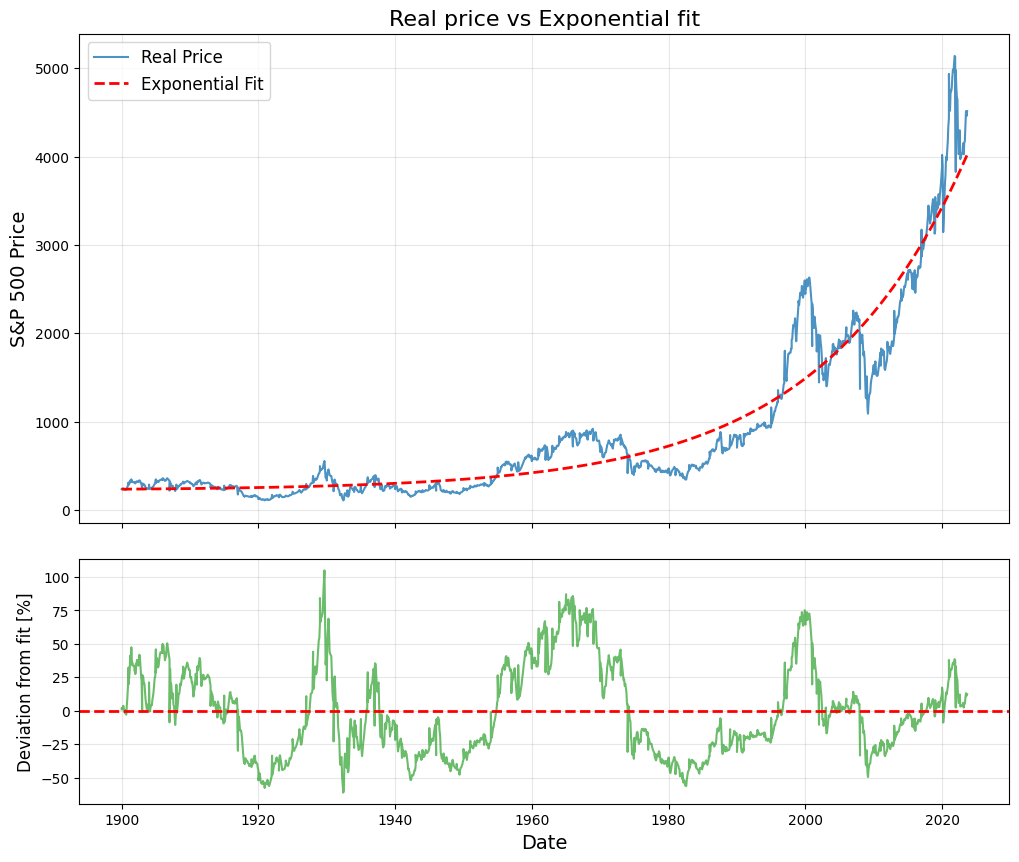

In [7]:
fig, (ax1, ax2) = pl.subplots(2, 1, figsize=(12, 10),
                              height_ratios=[2, 1],
                              sharex=True,
                              gridspec_kw={'hspace': 0.1})

ax1.plot(data['Real Price'], label='Real Price', alpha=0.8)
ax1.plot(data['Exponential Fit'], 'r--', label='Exponential Fit',
         linewidth=2)

ax1.set_ylabel('S&P 500 Price', fontsize=14)
ax1.set_title('Real price vs Exponential fit', fontsize=16)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

ax2.plot(data['Deviation'] * 100, color='tab:green', alpha=0.7)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Date', fontsize=14)
ax2.set_ylabel('Deviation from fit [%]', fontsize=12)
ax2.grid(True, alpha=0.3)

pl.tight_layout()
pl.show()

**Key Observations:**
- The index follows a long-term exponential trend
- There are seemingly random deviations from the exponential

## Triple Gaussian Mixture modeling

### Brownian motion extraction

We extract the stochastic component by computing month-to-month changes in relative deviation

In [8]:
data['Brownian Motion'] = data['Deviation'].diff().fillna(0)

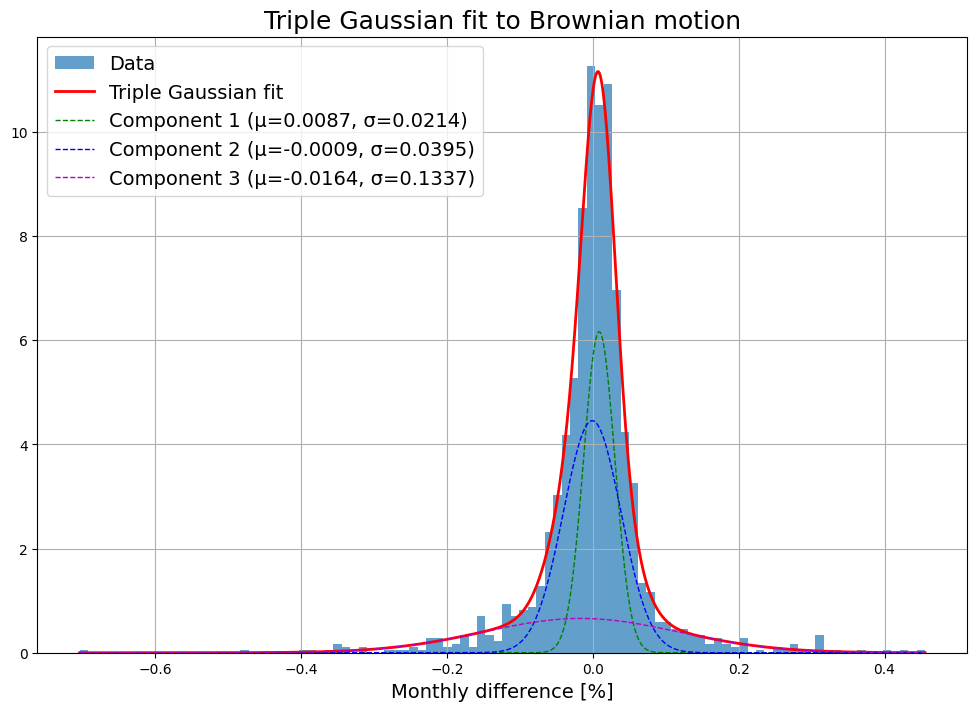

In [9]:
pl.figure(figsize=(12, 8))
pl.hist(data['Brownian Motion'], bins=100, alpha=0.7, density=True,
        label='Data')

x_fit = np.linspace(data['Brownian Motion'].min(),
                    data['Brownian Motion'].max(), 1000)

pl.plot(x_fit, monte_carlo_model.triple_gaussian_function(x_fit), 'r-',
        linewidth=2,
        label=f'Triple Gaussian fit')
pl.plot(x_fit, monte_carlo_model.gauss1_function(x_fit), 'g--',
        linewidth=1,
        label=f'Component 1 (μ={monte_carlo_model.triple_gauss_mu1:.4f}, σ={monte_carlo_model.triple_gauss_sigma1:.4f})')
pl.plot(x_fit, monte_carlo_model.gauss2_function(x_fit), 'b--',
        linewidth=1,
        label=f'Component 2 (μ={monte_carlo_model.triple_gauss_mu2:.4f}, σ={monte_carlo_model.triple_gauss_sigma2:.4f})')
pl.plot(x_fit, monte_carlo_model.gauss3_function(x_fit), 'm--',
        linewidth=1,
        label=f'Component 3 (μ={monte_carlo_model.triple_gauss_mu3:.4f}, σ={monte_carlo_model.triple_gauss_sigma3:.4f})')

pl.grid(True)
pl.legend(fontsize=14)
pl.xlabel('Monthly difference [%]', fontsize=14)
pl.title('Triple Gaussian fit to Brownian motion', fontsize=18)
pl.show()

**Key Observations:**
- Our triple Gaussian mixture fits the Brownian-motion component fairly well

## Model Validation

### Out-of-Sample Testing

We test our model's predictive power on post-2010 data (held-out test set):

In [10]:
test_data = data.loc[data.index > dt.datetime(2010, 1, 1)].sort_index()

In [11]:
mc_brownian = []
for _ in range(len(test_data)):
    mc_brownian.append(monte_carlo_model.draw())
mc_brownian = np.vstack(mc_brownian)

Let's draw samples directly from the triple Gaussian mixture model

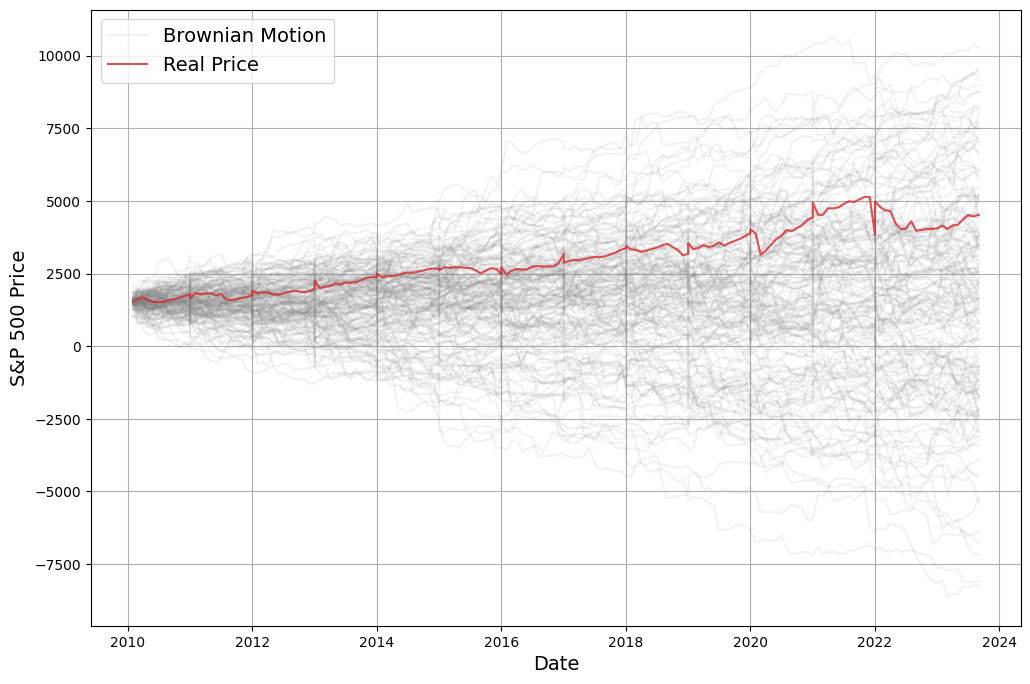

In [12]:
pl.figure(figsize=(12, 8))
for i in range(mc_brownian.shape[0]):
    pl.plot(
        (test_data['Deviation'].iloc[0] + np.cumsum(mc_brownian[:, i])) *
        test_data[
            'Exponential Fit'] + test_data['Exponential Fit'],
        color='grey',
        alpha=0.1,
        label='Brownian Motion' if i == 0 else None
    )
pl.plot(test_data['Real Price'], label='Real Price', color='tab:red', alpha=0.8)
pl.legend(fontsize=14)
pl.xlabel('Date', fontsize=14)
pl.ylabel('S&P 500 Price', fontsize=14)
pl.grid(True)
pl.show()

**Key Observations:**
- There are many paths which go bellow zero, which is impossible in reality
- Drawing samples from these paths is a waste of computing resources
- Paths going bellow zero cannot be just removed, because that would introduce bias to the model

## Future Price Simulation

Now we simulate future S&P 500 prices from 2023-09-01 (last date in our dataset) to 2025-09-01 starting at the last available value.

In [13]:
monte_carlo_model.simulate(
    max(data.index),
    dt.datetime(2025, 9, 1),
    start_value=data['Real Price'].iloc[-1]
)

#### Posterior distribution

Our Monte Carlo model simulated 10,000 (n_samples) experiments over the chosen time horizon. You can think of this as creating 10,000 parallel universes—each with events unfolding differently, producing a unique version of history every time.

Although each simulated history is different, they all share the same statistical properties as the S&P 500 in our real universe.

We can visualize these alternative scenarios through the posterior distribution, which captures the simulated end-of-period prices across all samples.

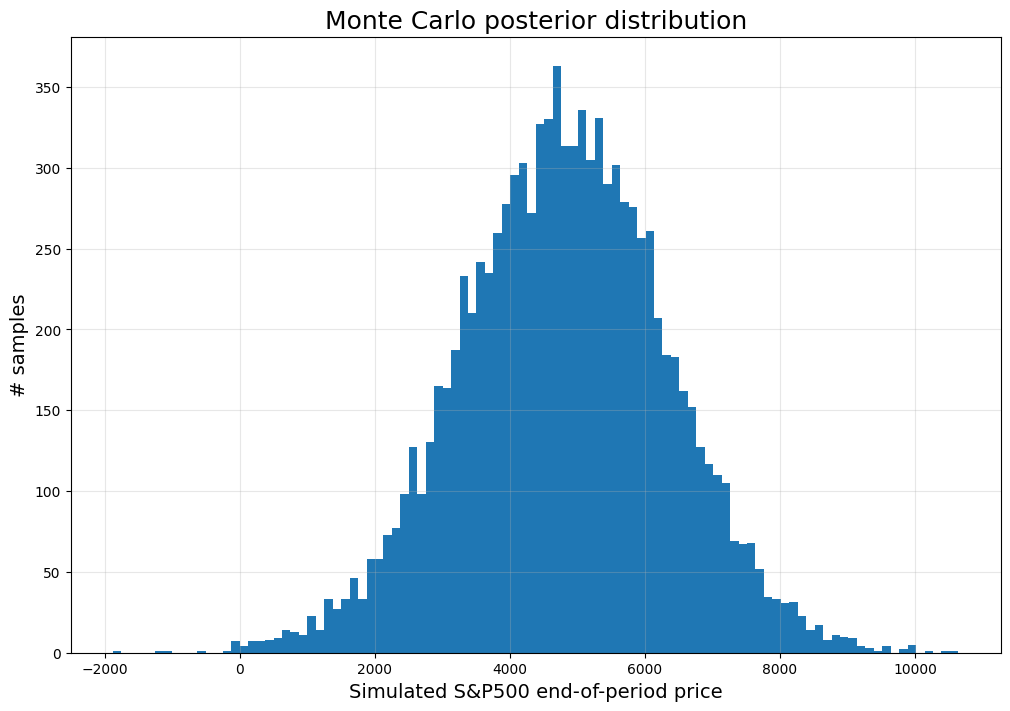

In [14]:
pl.figure(figsize=(12, 8))
prices, weights = monte_carlo_model.posterior
pl.title('Monte Carlo posterior distribution', fontsize=18)
pl.hist(
    prices,
    bins=100,
    weights=weights,
)
pl.grid(True, alpha=0.3)
pl.xlabel('Simulated S&P500 end-of-period price', fontsize=14)
pl.ylabel('# samples', fontsize=14)
pl.show()

**Key Observations:**
- The posterior values cluster around the most likely outcome
- The number of posterior samples falling within a given range reflects the probability of those values materializing
- We can approximate this posterior distribution with a Gaussian, which allows us to translate the Z-score of any given value into the probability of it occurring

#### Expected Value and Statistical Analysis

From our simulated data, we can estimate the most likely S&P 500 price on 2025-09-01, along with its expected standard deviation

In [15]:
prices, weights = monte_carlo_model.posterior
weighted_mean = np.average(prices, weights=weights)
variance = np.average((prices - weighted_mean)**2, weights=weights)
weighted_std = np.sqrt(variance)

print(f'Weighted expected S&P 500 price (2025-09-01): ${weighted_mean:.0f} ± ${weighted_std:.0f}')

Weighted expected S&P 500 price (2025-09-01): $4797 ± $1529


Now, let’s compare our simulated results with the actual S&P 500 value observed in the last week of August 2025 (at the time of writing)

In [16]:
real_price = yfinance.Ticker("^GSPC").history(
    start="2025-08-25",
    end="2025-08-26"
)['Close'].iloc[0]
print(f'Real S&P500 price: ${real_price:.0f}')

Real S&P500 price: $6439


In [17]:
z_score = (real_price - weighted_mean) / weighted_std
probability = 1 - stats.norm.cdf(z_score)
print(f'Z-score: {z_score:.4f}')
print(f'Probability: {probability * 100:.2f} %')

Z-score: 1.0741
Probability: 14.14 %


The current price exceeds the predicted most likely value. According to our model, there is a 14.5% probability of this outcome occurring.

### What does this imply?

There are several possible interpretations:

- Of course, our model has limitations. It assumes each time step is independent of the past (a Markov process), which doesn’t fully reflect reality. In practice:
  - Bull markets tend to attract additional investment
  - Bear markets are often viewed as buying opportunities
  - Assets have intrinsic values, which makes prices falling below certain thresholds far less likely than our simple model suggests
- The stock market may be currently overvalued, suggesting a higher likelihood of corrections
- Alternatively, structural changes in the market or economy—unrepresented in historical data—could be supporting sustained growth beyond past trends

### Key Takeaways

1. **Modeling with Monte Carlo**: Complex or poorly understood processes can be modeled using random distributions, which Monte Carlo methods then leverage to simulate possible future outcomes

2. **Assessing Future Outcomes**: Posterior distributions allow us to estimate the likelihood of future outcomes, providing a powerful tool for assessing risks and opportunities

3. **Statistical Weight Implementation**: Variance reduction techniques allow our model to concentrate computational effort on the most important regions of the outcome space